# Load Model For Genception

## SAE Params

In [1]:
HIDDEN_SIZE = 256

## Imports

In [2]:
import pickle
import numpy as np
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression

import pandas as pd

import torch
from torch import nn 
from torch.utils.data import DataLoader

from models_and_data.nn import NeuralNetwork
from models_and_data.sae import SparseAutoencoder
from models_and_data.edgedataset import EdgeDataset

from models_and_data.model_helpers import (evaluate_and_gather_activations, get_sublabel_data, 
    get_top_N_features, extract_activations, load_intermediate_labels, seed_worker, SNE_plot_2d, SNE_plot_3d)

## Set Device to GPU

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cuda


## Load Data

In [4]:
# train data
train_images = load_intermediate_labels("./intermediate-labels/first_layer/train_images.pkl")
train_labels = load_intermediate_labels("./intermediate-labels/first_layer/train_labels.pkl")

# test data
test_images = load_intermediate_labels("./intermediate-labels/first_layer/test_images.pkl")
test_labels = load_intermediate_labels("./intermediate-labels/first_layer/test_labels.pkl")

# Model Loading

## Model Result Replication

In [5]:
seed = 42
generator = torch.Generator().manual_seed(seed)

NUM_WORKERS = 4
if device.type.lower() == "cpu":
    NUM_WORKERS = 0

# training data
train_dataset = EdgeDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=NUM_WORKERS,
                          worker_init_fn=seed_worker, generator=generator, pin_memory=True)

# test data
test_dataset = EdgeDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

In [6]:
model = NeuralNetwork().to(device)
sae_hidden_one = SparseAutoencoder(input_size=16, hidden_size=HIDDEN_SIZE).to(device)
sae_hidden_two = SparseAutoencoder(input_size=16, hidden_size=HIDDEN_SIZE).to(device)

In [7]:
# best_model_path = "./SAE-Results/256-0.75/results/baseline/model_state_dict.pth"
# df_path = "./interp/baseline"

# best_model_path = "./SAE-Results/256-0.75/results/F0/models/25_top/best_model_lf_0.14.pth"
# df_path = "./interp/F0"

# best_model_path = "./SAE-Results/256-0.75/results/F1/models/25_top_0.14/25_top/best_model_lf_0.06.pth"
# df_path = "./interp/F1"

best_model_path = "./SAE-Results/256-0.75/results/F2/models/25_top_0.14_25_top_0.06/25_top/best_model_lf_0.18.pth"
df_path = "./interp/F2"

checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
sae_hidden_one.load_state_dict(checkpoint['sae_one_state_dict'])
sae_hidden_two.load_state_dict(checkpoint['sae_two_state_dict'])

<All keys matched successfully>

## Verify Correct Model

In [8]:
train_results = evaluate_and_gather_activations(model, sae_hidden_one, sae_hidden_two, train_loader, device)
Z_train_one, Z_train_two, y_train = train_results["Z_one"], train_results["Z_two"], train_results["y"]

test_results = evaluate_and_gather_activations(model, sae_hidden_one, sae_hidden_two, test_loader, device)
Z_test_one, Z_test_two, y_test = test_results["Z_one"], test_results["Z_two"], test_results["y"]

print(f"Model acc: {test_results['accuracy']}")

Model acc: 93.66


In [9]:
sparsity_one = np.mean(Z_test_one > 1e-5) * Z_test_one.shape[1]
sparsity_two = np.mean(Z_test_two > 1e-5) * Z_test_two.shape[1]
print(f"Average Non-Zero Features per Image (Hidden One): {sparsity_one:.2f}")
print(f"Average Non-Zero Features per Image (Hidden Two): {sparsity_two:.2f}")

Average Non-Zero Features per Image (Hidden One): 43.12
Average Non-Zero Features per Image (Hidden Two): 27.53


In [10]:
# print("\n--- Training Linear Probes ---")
# clf_one = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
# clf_one.fit(Z_train_one, y_train)
# acc_one = clf_one.score(Z_test_one, y_test)
# print(f"Linear Probe Accuracy (Hidden One): {acc_one:.2%}")

# clf_two = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
# clf_two.fit(Z_train_two, y_train)
# acc_two = clf_two.score(Z_test_two, y_test)
# print(f"Linear Probe Accuracy (Hidden Two): {acc_two:.2%}")

# Clustering

In [11]:
activation_data = extract_activations(
    data_loader=test_loader,
    model=model,
    sae_one=sae_hidden_one,
    sae_two=sae_hidden_two,
    device=device
)

Extracting Activations: 100%|██████████████████████████████████████████| 79/79 [00:00<00:00, 111.67it/s]


In [12]:
sparse_act_one = activation_data["sparse_one"]
max_feature_indices_sp_one = np.argmax(sparse_act_one, axis=1)

# Metrics

In [13]:
from sklearn.metrics import adjusted_rand_score, silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Suppose:
X = activation_data['sparse_one']        # your n×d sparse feature matrix
true_labels = activation_data['labels']  # ground-truth digits
pred_labels = max_feature_indices_sp_one  # argmax of your sparse codes

ari = adjusted_rand_score(true_labels, pred_labels)
sil_unsup = silhouette_score(X,          pred_labels)   # how tight are your feature-induced clusters?
sil_sup   = silhouette_score(X,          true_labels)   # how well do features separate the real digits?
db        = davies_bouldin_score(X,      true_labels)   # with true labels
ch        = calinski_harabasz_score(X,   true_labels)

metrics_df = pd.DataFrame({
    'Metric': [
        'Adjusted Rand Index (ARI)',
        'Silhouette (Unsupervised)',
        'Silhouette (Supervised)',
        'Davies-Bouldin Index',
        'Calinski-Harabasz Index'
    ],
    'Value': [ari, sil_unsup, sil_sup, db, ch]
})

metrics_df['Value'] = metrics_df['Value'].round(3)
metrics_df.to_csv(f"{df_path}/metrics.csv")
print(metrics_df)

                      Metric     Value
0  Adjusted Rand Index (ARI)     0.281
1  Silhouette (Unsupervised)    -0.021
2    Silhouette (Supervised)     0.258
3       Davies-Bouldin Index     1.404
4    Calinski-Harabasz Index  1557.652


# TSNE Plots

In [14]:
tsne = TSNE(n_components=2, random_state=42)
activations_2d = tsne.fit_transform(sparse_act_one)

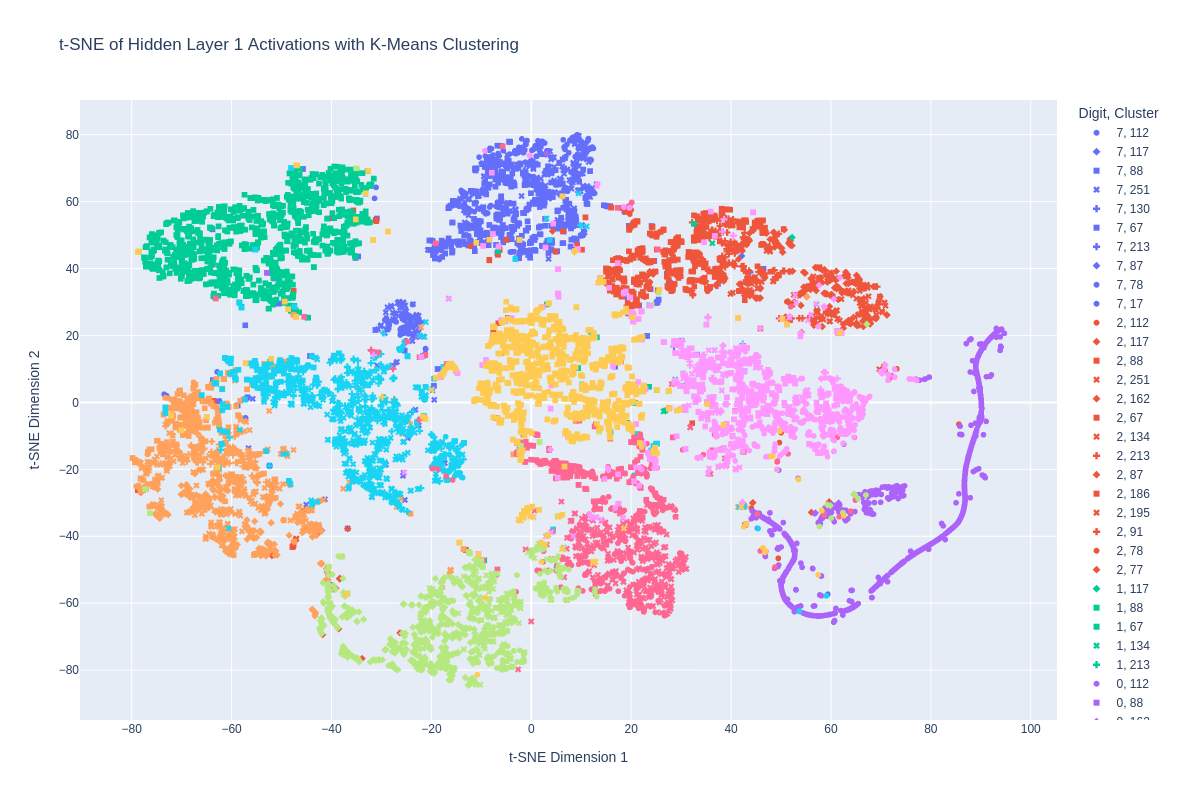

In [15]:
SNE_plot_2d(activations_2d=activations_2d, labels=activation_data["labels"], 
            cluster_labels=max_feature_indices_sp_one, height=800, width=800)

## More Mathematical Analysis

In [ ]:
df_high_dim = pd.DataFrame(sparse_act_one)
df_high_dim['cluster'] = max_feature_indices_sp_one

df = pd.DataFrame({
    'Class': activation_data["labels"],
    'Cluster': max_feature_indices_sp_one,
    'X': activations_2d[:, 0],
    'Y': activations_2d[:, 1],
})

In [ ]:
# df.query('Class == 1 and Cluster == 88')

In [ ]:
def calculate_subgroup_metrics(subgroup):
    centroid_x = subgroup['X'].mean()
    centroid_y = subgroup['Y'].mean()

    squared_distances = (subgroup['X'] - centroid_x)**2 + (subgroup['Y'] - centroid_y)**2
    subgroup_mse = squared_distances.mean()
    count = len(subgroup)

    return pd.Series({
        'Count': count,
        'Centroid_X': centroid_x,
        'Centroid_Y': centroid_y,
        'Subgroup_MSE': subgroup_mse
    })

final_summary = df.groupby(['Class', 'Cluster']).apply(calculate_subgroup_metrics)
final_summary = final_summary.sort_values('Count', ascending=False)
final_summary = final_summary.round(2)

In [ ]:
flattened_df = final_summary.reset_index().sort_values(by=['Class', 'Cluster']).reset_index(drop=True)
flattened_df.head()

In [ ]:
short_df = flattened_df.query("Count >= 250").reset_index(drop=True)
short_df

In [ ]:
class_df = df.groupby(['Class']).apply(calculate_subgroup_metrics)
class_df_flat = class_df.reset_index()
class_df_flat

In [ ]:
df.to_csv(f"{df_path}/individual_data.csv")
flattened_df.to_csv(f"{df_path}/cluster_class_data.csv")
short_df.to_csv(f"{df_path}/cluster_class_data_shortened.csv")
class_df.to_csv(f"{df_path}/class_data.csv")

# 3D

In [ ]:
# tsne = TSNE(n_components=3, random_state=42)
# activations_3d = tsne.fit_transform(sparse_act_one)

In [ ]:
# SNE_plot_3d(activations_3d=activations_3d, labels=activation_data["labels"], max_feature_indices_sp_one=max_feature_indices_sp_one)